In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
train_df = pd.read_csv('train_features_balanced.csv')
val_df = pd.read_csv('validation_features.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print("\nFeatures in dataset:")
print(train_df.columns.tolist())

Training data shape: (3933, 41)
Validation data shape: (638, 41)

Features in dataset:
['filename', 'raga', 'spec_cent', 'spec_bw', 'bigram_diversity', 'trigram_diversity', 'chroma_0', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'delta_chroma_0', 'delta_chroma_1', 'delta_chroma_2', 'delta_chroma_3', 'delta_chroma_4', 'delta_chroma_5', 'delta_chroma_6', 'delta_chroma_7', 'delta_chroma_8', 'delta_chroma_9', 'delta_chroma_10', 'delta_chroma_11', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10']


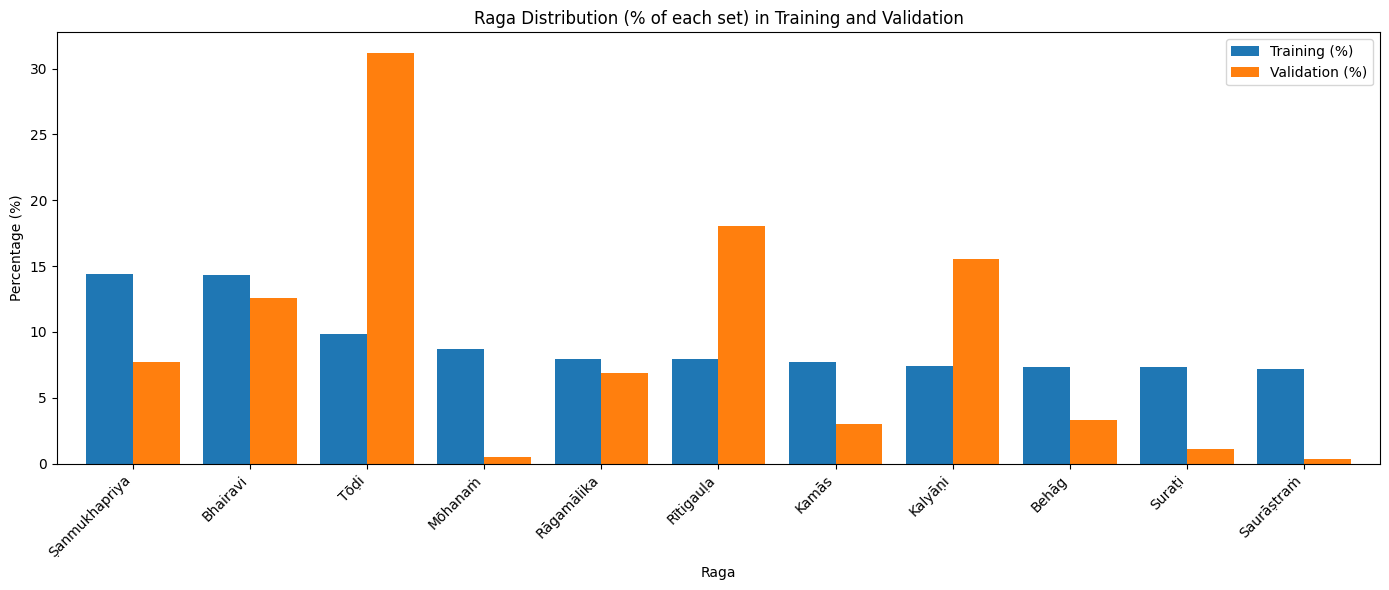

Total number of unique ragas (union of train/val): 11

Training set distribution (%):
raga
Ṣanmukhapriya    14.4
Bhairavi         14.3
Tōḍi              9.8
Mōhanaṁ           8.7
Rītigauḷa         7.9
Rāgamālika        7.9
Kamās             7.7
Kalyāṇi           7.4
Behāg             7.3
Suraṭi            7.3
Saurāṣtraṁ        7.2
Name: proportion, dtype: float64

Validation set distribution (%):
raga
Tōḍi             31.2
Rītigauḷa        18.0
Kalyāṇi          15.5
Bhairavi         12.5
Ṣanmukhapriya     7.7
Rāgamālika        6.9
Behāg             3.3
Kamās             3.0
Suraṭi            1.1
Mōhanaṁ           0.5
Saurāṣtraṁ        0.3
Name: proportion, dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Percentages per raga within each split
train_raga_pct = train_df['raga'].value_counts(normalize=True) * 100
val_raga_pct = val_df['raga'].value_counts(normalize=True) * 100

# Ensure both splits share the same index (all ragas seen in either split)
all_ragas = sorted(set(train_raga_pct.index) | set(val_raga_pct.index))
distribution_df = pd.DataFrame({
    'Training (%)': train_raga_pct.reindex(all_ragas),
    'Validation (%)': val_raga_pct.reindex(all_ragas)
}).fillna(0)

# Optional: sort bars by Training percentage (descending)
distribution_df = distribution_df.sort_values('Training (%)', ascending=False)

# Plot
ax = distribution_df.plot(kind='bar', width=0.8, figsize=(14, 6))
plt.xlabel('Raga')
plt.ylabel('Percentage (%)')
plt.title('Raga Distribution (% of each set) in Training and Validation')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Summary prints (optional)
print(f"Total number of unique ragas (union of train/val): {len(all_ragas)}")
print("\nTraining set distribution (%):")
print(train_raga_pct.sort_values(ascending=False).round(1))
print("\nValidation set distribution (%):")
print(val_raga_pct.sort_values(ascending=False).round(1))


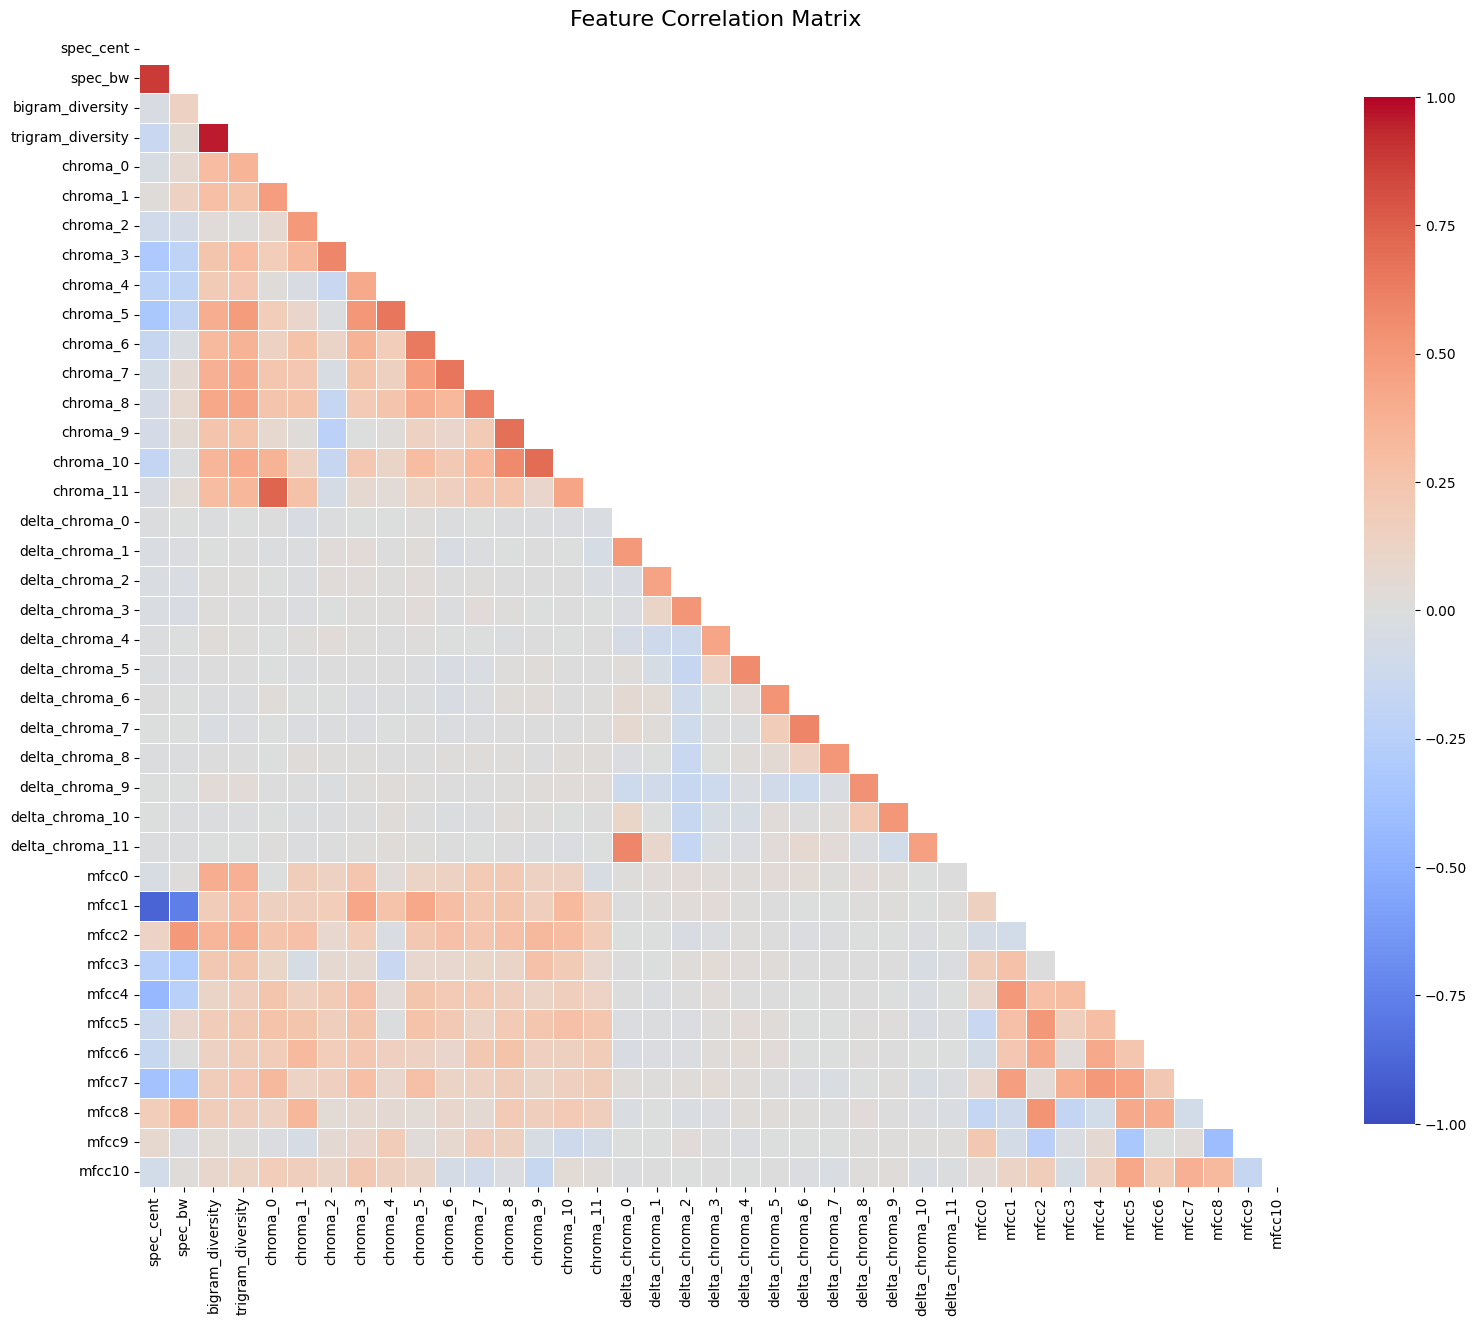

In [4]:
# Select only numeric features (exclude filename and raga)
feature_cols = [col for col in train_df.columns if col not in ['filename', 'raga']]

# Calculate correlation matrix
correlation_matrix = train_df[feature_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
# Define feature columns
feature_cols = [col for col in train_df.columns if col not in ['filename', 'raga']]

# Prepare training data
X_train = train_df[feature_cols]
y_train = train_df['raga']

# Prepare validation data
X_val = val_df[feature_cols]
y_val = val_df['raga']

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

print(f"Number of features: {len(feature_cols)}")
print(f"Number of classes: {len(le.classes_)}")
print(f"\nRaga classes: {list(le.classes_)}")
print(f"\nTraining set shape: X={X_train.shape}, y={y_train_encoded.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val_encoded.shape}")

Number of features: 39
Number of classes: 11

Raga classes: ['Behāg', 'Bhairavi', 'Kalyāṇi', 'Kamās', 'Mōhanaṁ', 'Rāgamālika', 'Rītigauḷa', 'Saurāṣtraṁ', 'Suraṭi', 'Tōḍi', 'Ṣanmukhapriya']

Training set shape: X=(3933, 39), y=(3933,)
Validation set shape: X=(638, 39), y=(638,)


In [6]:
# Train Random Forest
print("Training Random Forest Classifier...")

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_classifier.fit(X_train, y_train_encoded)

# Make predictions
y_pred_rf = rf_classifier.predict(X_val)

# Evaluate
rf_accuracy = accuracy_score(y_val_encoded, y_pred_rf)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred_rf, 
                          target_names=le.classes_, 
                          digits=3))

Training Random Forest Classifier...

Random Forest Accuracy: 0.0329

Classification Report:
               precision    recall  f1-score   support

        Behāg      0.000     0.000     0.000        21
     Bhairavi      0.087     0.100     0.093        80
      Kalyāṇi      0.000     0.000     0.000        99
        Kamās      0.140     0.368     0.203        19
      Mōhanaṁ      0.029     0.333     0.053         3
   Rāgamālika      0.030     0.023     0.026        44
    Rītigauḷa      0.000     0.000     0.000       115
   Saurāṣtraṁ      0.042     0.500     0.077         2
       Suraṭi      0.000     0.000     0.000         7
         Tōḍi      0.029     0.015     0.020       199
Ṣanmukhapriya      0.000     0.000     0.000        49

     accuracy                          0.033       638
    macro avg      0.032     0.122     0.043       638
 weighted avg      0.027     0.033     0.026       638



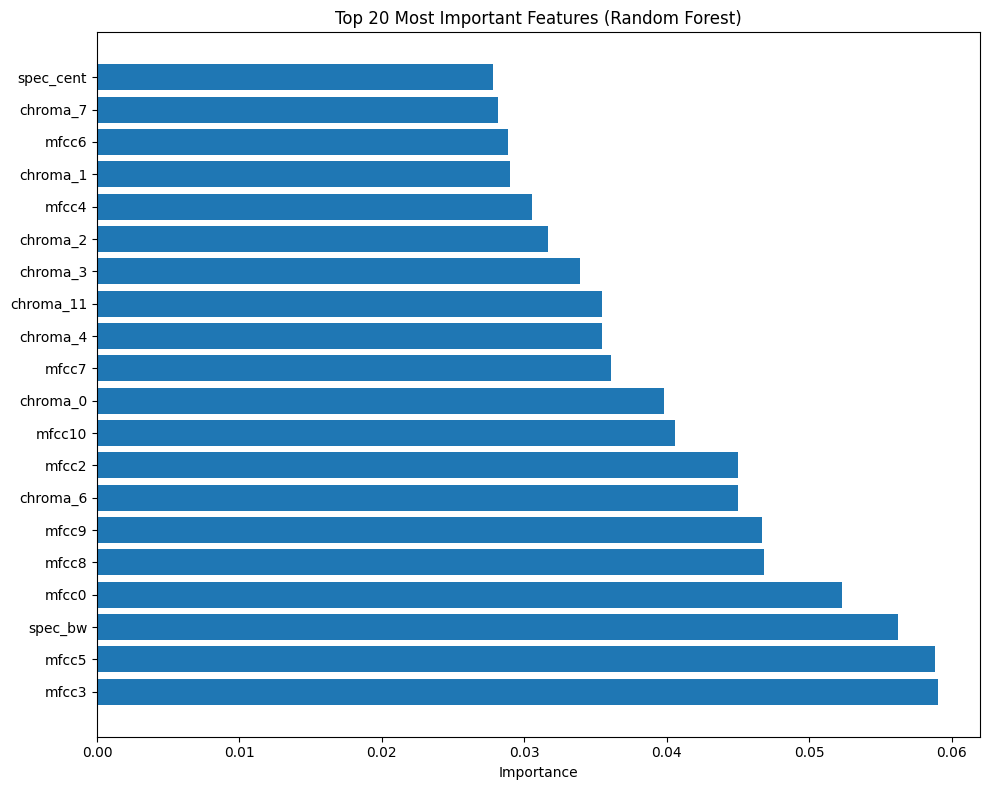

Top 10 Most Important Features:
     feature  importance
31     mfcc3    0.059047
33     mfcc5    0.058837
1    spec_bw    0.056220
28     mfcc0    0.052282
36     mfcc8    0.046843
37     mfcc9    0.046685
10  chroma_6    0.044998
30     mfcc2    0.044992
38    mfcc10    0.040619
4   chroma_0    0.039793


In [7]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

In [8]:
# Train SVM with scaling
print("Training Support Vector Machine...")

# Create pipeline with scaler and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

# Train the model
svm_pipeline.fit(X_train, y_train_encoded)

# Make predictions
y_pred_svm = svm_pipeline.predict(X_val)

# Evaluate
svm_accuracy = accuracy_score(y_val_encoded, y_pred_svm)
print(f"\nSVM Accuracy: {svm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred_svm, 
                          target_names=le.classes_, 
                          digits=3))

Training Support Vector Machine...

SVM Accuracy: 0.0815

Classification Report:
               precision    recall  f1-score   support

        Behāg      0.036     0.048     0.041        21
     Bhairavi      0.165     0.225     0.190        80
      Kalyāṇi      0.000     0.000     0.000        99
        Kamās      0.193     0.842     0.314        19
      Mōhanaṁ      0.120     1.000     0.214         3
   Rāgamālika      0.000     0.000     0.000        44
    Rītigauḷa      0.103     0.026     0.042       115
   Saurāṣtraṁ      0.024     0.500     0.047         2
       Suraṭi      0.000     0.000     0.000         7
         Tōḍi      0.263     0.050     0.084       199
Ṣanmukhapriya      0.000     0.000     0.000        49

     accuracy                          0.082       638
    macro avg      0.082     0.245     0.085       638
 weighted avg      0.129     0.082     0.070       638



In [9]:
# Train KNN with scaling
print("Training K-Nearest Neighbors...")

# Create pipeline with scaler and KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

# Train the model
knn_pipeline.fit(X_train, y_train_encoded)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_val)

# Evaluate
knn_accuracy = accuracy_score(y_val_encoded, y_pred_knn)
print(f"\nKNN Accuracy: {knn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred_knn, 
                          target_names=le.classes_, 
                          digits=3))

Training K-Nearest Neighbors...

KNN Accuracy: 0.0768

Classification Report:
               precision    recall  f1-score   support

        Behāg      0.000     0.000     0.000        21
     Bhairavi      0.194     0.237     0.213        80
      Kalyāṇi      0.021     0.010     0.014        99
        Kamās      0.143     0.263     0.185        19
      Mōhanaṁ      0.038     0.667     0.071         3
   Rāgamālika      0.000     0.000     0.000        44
    Rītigauḷa      0.167     0.070     0.098       115
   Saurāṣtraṁ      0.024     0.500     0.047         2
       Suraṭi      0.000     0.000     0.000         7
         Tōḍi      0.283     0.065     0.106       199
Ṣanmukhapriya      0.000     0.000     0.000        49

     accuracy                          0.077       638
    macro avg      0.079     0.165     0.067       638
 weighted avg      0.150     0.077     0.086       638



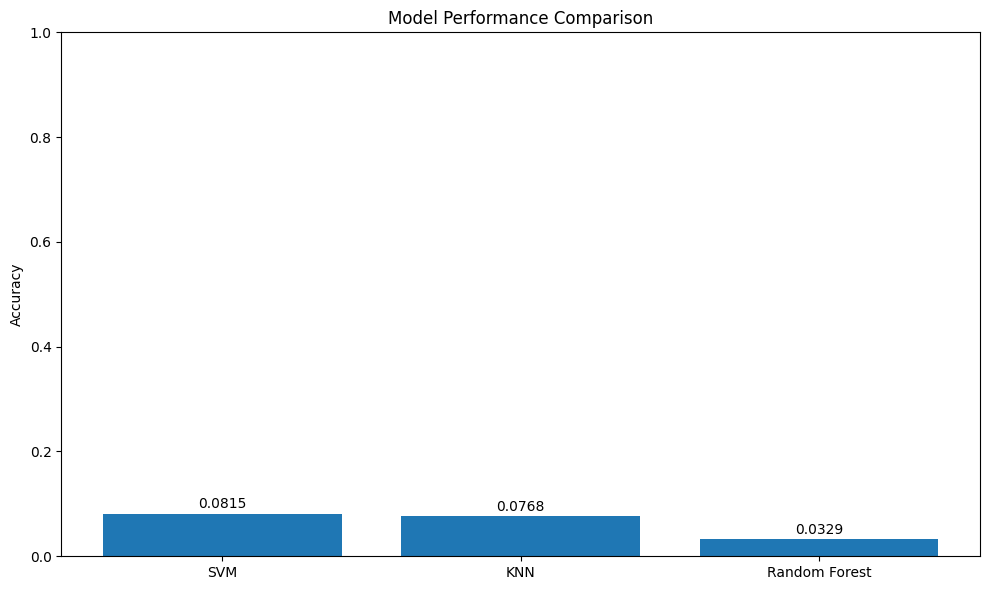

Model Performance Summary:
           Model  Accuracy
1            SVM  0.081505
2            KNN  0.076803
0  Random Forest  0.032915

Best performing model: SVM with accuracy 0.0815


In [10]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'KNN'],
    'Accuracy': [rf_accuracy, svm_accuracy, knn_accuracy]
}).sort_values('Accuracy', ascending=False)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Accuracy'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
for i, v in enumerate(results['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

print("Model Performance Summary:")
print(results)
print(f"\nBest performing model: {results.iloc[0]['Model']} with accuracy {results.iloc[0]['Accuracy']:.4f}")

<Figure size 1200x1000 with 0 Axes>

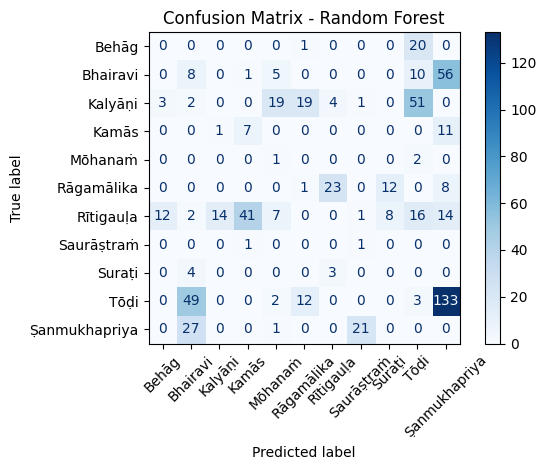

In [11]:
# Plot confusion matrix for the best model (assuming Random Forest performed best)
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val_encoded, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()